In [2]:
import pandas as pd
import numpy as np
import requests
import re
from Bio import SeqIO
import subprocess
from random import sample

def ko2genes(ko):
    url = 'http://rest.kegg.jp/link/genes/' + ko
    r = requests.get(url)
    geneKO = pd.DataFrame([x.split('\t') for x in r.text.split('\n')],columns=['ko','gene'])
    geneKO = geneKO.iloc[0:-1]
    return geneKO

def download_seqs(geneList,fileName,batchSize):    
    geneList_chunks = [geneList[i * batchSize:(i + 1) * batchSize] for i in range((len(geneList) + batchSize - 1) // batchSize )]
    with open(fileName,'w') as fastafile:
        for sglist in geneList_chunks:
            url =  'http://rest.kegg.jp/get/' + "+".join(sglist) + '/aaseq'
            fseqs = requests.get(url).text
            fastafile.write(fseqs)

            
def msaSeq2df(seq,indexStart):
    idx = []
    resid = []
    j = indexStart;
    for i in seq:
        resid.append(i)
        if i == '-':
            idx.append(np.nan)
        else:
            idx.append(j)
            j = j+1
    
    return pd.DataFrame({'residue': resid, 'index': idx})

def ecogenes():
    url = 'http://rest.kegg.jp/link/ko/eco'
    r = requests.get(url)
    geneKO = pd.DataFrame([x.split('\t') for x in r.text.split('\n')],columns=['gene','ko'])
    geneKO = geneKO.iloc[0:-1]
    return geneKO

get_resid = lambda x: [x for x in re.findall(r'\D',x) if len(x)>0][0]
get_resid_idx = lambda x: [int(x) for x in re.findall(r'\d*',x) if len(x)>0][0]


# load the structural annotations and only keep NAD binding enzymes with single D or E residues 
structure = pd.read_csv('../assets/structure/oxidoreductases_residue_annotation.csv',index_col=0)
structure = structure[structure['Coenzyme'].isin(['NAD','NADH'])]
structure = structure[structure['Residues'].apply(lambda x: (len(x.split(';')) < 2) & (x[0] in ['E','D']))]

taxonomy = pd.read_csv('../assets/kegg/KEGG_taxonomy_final.csv')

In [1]:
seqMax = 1000

In [43]:
# perform MSA using either original KO group sequences or downsample

for idx,row in structure.iterrows():
    ko = row.KO
    ecoli_gene = 'eco:' + idx
    homolog = row['Homolog-KEGG']
    gene_set = list(set([ecoli_gene,homolog]))
    seq_dict = SeqIO.to_dict(SeqIO.parse('../assets/kegg/orthogroups/' + ko + '.fasta','fasta'));
    if len(seq_dict) > seqMax:
        g = seqMax
        population = [x for x in list(seq_dict) if x not in gene_set]
        sample_list = sample(population,seqMax-len(gene_set))
        sample_list = sample_list + gene_set
        seq_dict_subset = {x:y for x,y in seq_dict.items() if x in sample_list}
        fileName = '../assets/kegg/orthogroups/subset/' + ko + '.1k.fasta'
        with open(fileName,'w') as fastafile:
            #SeqIO.write(seq_dict_subset,fastafile,'fasta')
            SeqIO.write(seq_dict_subset.values(), fastafile, 'fasta')
            print('downsampled ' + str(seqMax) + ' sequences for KO: ' + ko + '; saved to file: ' + fileName)

    else:
        g = len(seq_dict)
        filename = '../assets/kegg/orthogroups/' + ko + '.fasta'
    
    # perform msa on all orthogroups (or subsets of 1k sequences)
    fin = fileName
    fout = '../assets/kegg/orthogroups/subset/msa/' + ko + '.MSA.fasta'
    call = '/Users/Joshua.Goldford/opt/miniconda3/bin/muscle -in ' + fin + ' -out ' + fout
    subprocess.call(call,shell=True)
    print('finished with mutiple sequence alignment for KO group: ' + ko + '; number of seqs: ' + str(g))

downsampled 1000 sequences for KO: K00215; saved to file: ../assets/kegg/orthogroups/subset/K00215.1k.fasta
finished with mutiple sequence alignment for KO group: K00215; number of seqs: 1000
downsampled 1000 sequences for KO: K00382; saved to file: ../assets/kegg/orthogroups/subset/K00382.1k.fasta
finished with mutiple sequence alignment for KO group: K00382; number of seqs: 1000
downsampled 1000 sequences for KO: K00121; saved to file: ../assets/kegg/orthogroups/subset/K00121.1k.fasta
finished with mutiple sequence alignment for KO group: K00121; number of seqs: 1000
downsampled 1000 sequences for KO: K03778; saved to file: ../assets/kegg/orthogroups/subset/K03778.1k.fasta
finished with mutiple sequence alignment for KO group: K03778; number of seqs: 1000
downsampled 1000 sequences for KO: K13953; saved to file: ../assets/kegg/orthogroups/subset/K13953.1k.fasta
finished with mutiple sequence alignment for KO group: K13953; number of seqs: 1000
downsampled 1000 sequences for KO: K0002

In [44]:
ko_list =  [];
residue_list = []
residue_ref_idx = []
residue_msa_idx = []
count_occured = []
count_not_occured = []
frac_occured = []

dfs = []

for idx,row in structure.iterrows():
    ko = row.KO
    msa_file = '../assets/kegg/orthogroups/subset/msa/' + ko + '.MSA.fasta'
    seq_dict = SeqIO.to_dict(SeqIO.parse(msa_file,'fasta'))
    if structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0] in list(seq_dict):
        seq_id = structure[structure.KO == ko]['Homolog-KEGG'].tolist()[0]
        r = structure[structure.KO == ko].Residues[0].split(';')
        r  = [x for x in r if x not in ['Unclear',None]]
        if len(r) > 0:
            r = pd.DataFrame({'residue': [get_resid(y) for y in r],'index':[get_resid_idx(y) for y in r]})
            seq = str(seq_dict[seq_id].seq)
            seqdf = msaSeq2df(seq,1)
            sdf = seqdf[seqdf['index'].isin(r['index'].tolist())]
            for midx,row2 in sdf.iterrows():
                chars = [y.seq[midx] for y in list(seq_dict.values())]
                z = pd.DataFrame({'idx':chars}).reset_index().groupby('idx').count()
                z2 = z.reset_index()
                z2.columns = ['residue','numSeqs']
                z2['ref_residue'] = row2.residue
                z2['ref_residue_idx'] = row2['index']
                z2['KO'] = ko
                dfs.append(z2)
                #frac = z.loc[row2.residue]['index'] / z['index'].sum()
                ##ko_list.append(ko)
                #residue_list.append(row2.residue)
                #residue_ref_idx.append(row2['index'])
                #residue_msa_idx.append(midx)
                #count_occured.append(z.loc[row2.residue]['index'])
                #count_not_occured.append(z['index'].sum() - z.loc[row2.residue]['index'])
                #frac_occured.append(frac)

dfs = pd.concat(dfs,axis=0)                
r = {'KO': [], 'de_seq': [], 'n_seq': [],'wt_residue':[]}
dfs_new = []
for idx,dff in dfs.groupby('KO'):
    de_seqs = dff[[x in ['D','E'] for x in dff['residue']]].numSeqs.sum()
    nseqs = dff[[x not in ['D','E'] for x in dff['residue']]].numSeqs.sum()
    r['KO'].append(idx); r['de_seq'].append(de_seqs); r['n_seq'].append(nseqs)
    r['wt_residue'].append(dff.ref_residue.unique())
    dff['proportion'] = dff['numSeqs'] / dff['numSeqs'].sum()
    dfs_new.append(dff)
r = pd.DataFrame(r)
r = r[r['wt_residue'].apply(lambda x: x[0] in ['D','E'])]
#results = pd.DataFrame({'ko':ko_list,'residue':residue_list,'idx': residue_ref_idx, 'midx': residue_msa_idx, 'count': count_occured, 'ncount': count_not_occured, 'frac': frac_occured})    

In [57]:
dfst_normalized = pd.read_hdf('../scc/relativeGrowthRates.StoichAndThermo.MR4.hdf','df')

In [51]:
ids = structure.reset_index()[['KO','gene name','gene id']]
ids['id'] = ids['gene name'] + ' (' + ids['KO'] + ')'

In [58]:
dfst_normalized = dfst_normalized.rename(columns=dict(zip(ids['gene id'],ids['id'])))

In [55]:
dfs_new = pd.concat(dfs_new,axis=0)
dfs_new = dfs_new[dfs_new['ref_residue'].isin(['D','E'])]
prop = dfs_new.pivot_table(index='KO',columns = ['residue'],values='proportion').fillna(0).T
p = prop.T.join(structure.reset_index()[['KO','gene name']].set_index('KO')).reset_index()
p['id'] = p['gene name'] + ' (' + p['KO'] + ')'
p.set_index(['KO','gene name'],inplace=True)
p.set_index('id',inplace=True)


In [70]:
mean_rgr = dfst_normalized[[x for x in list(p.T) if x in list(dfst_normalized)]].min().sort_values()

In [71]:
conservation = p['E'] + p['D']

In [72]:
mean_rgr

leuB (K00052)    0.000000
pdxB (K03473)    0.000000
gapA (K00134)    0.000401
mdh (K00024)     0.006426
frmA (K00121)    0.734684
tdh (K00060)     0.997261
rfbD (K00067)    0.999998
wecC (K02472)    0.999998
astD (K06447)    0.999998
ugd (K00012)     0.999998
dapB (K00215)    0.999998
maeA (K00027)    0.999998
hisD (K00013)    0.999998
dtype: float64

In [132]:
cpr = pd.DataFrame(conservation,columns = ['conservation']).join(pd.DataFrame(mean_rgr,columns=['mean growth rate'])).dropna()

In [83]:
gs = pd.read_csv('../assets/mutantGeneSet.reactionDirectionUpdateRules.MR4.csv')

In [125]:
ids['gene id'] = ids['gene id'].apply(lambda x: x.strip())

In [129]:
nad_genes = gs[gs['wild type coenzyme'].isin(['NAD(H)'])].gene.tolist()

In [131]:
ids[ids['gene id'].isin(nad_genes)].id.tolist()

['lpdA (K00382)',
 'frmA (K00121)',
 'maeA (K00027)',
 'astD (K06447)',
 'gapA (K00134)',
 'hisD (K00013)',
 'ugd (K00012)',
 'pdxB (K03473)',
 'mdh (K00024)',
 'tdh (K00060)',
 'wecC (K02472)',
 'leuB (K00052)',
 'allD (K00073)',
 'dmlA (K07246)',
 'tyrA (K14187)',
 'fucO (K00048)',
 'yiaK (K08092)']

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt


def label_point(x, y, val, ax):
    a = pd.DataFrame({'x': x, 'y': y, 'val': val})
    for i, point in a.iterrows():
        ax.text(point['x']+.002, point['y'], point['val'])
        
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [133]:
idl = ids[ids['gene id'].isin(nad_genes)].id.tolist()
cpr = cpr.reset_index()
cpr_nad = cpr[cpr.id.isin(idl)]

In [134]:
cpr_nad.sort_values('mean growth rate')

,id,conservation,mean growth rate
4,leuB (K00052),0.937,0.000000
11,pdxB (K03473),1.000,0.000000
8,gapA (K00134),0.881,0.000401
2,mdh (K00024),0.975,0.006426
7,frmA (K00121),0.996,0.734684
5,tdh (K00060),0.993,0.997261
10,wecC (K02472),0.965,0.999998
12,astD (K06447),0.997,0.999998
0,ugd (K00012),0.973,0.999998
3,maeA (K00027),0.938,0.999998


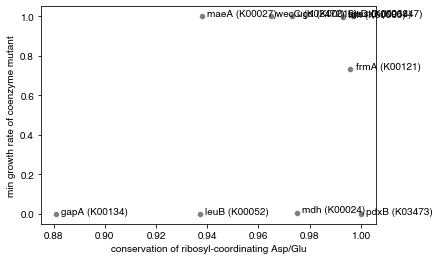

In [135]:

ax = sns.scatterplot(x='conservation',y='mean growth rate',data=cpr_nad,color='grey')
label_point(cpr_nad['conservation'].tolist(),cpr_nad['mean growth rate'].tolist(),cpr_nad['id'].tolist(),ax)
plt.xlabel('conservation of ribosyl-coordinating Asp/Glu')
plt.ylabel('min growth rate of coenzyme mutant')
plt.savefig('orthogroups.DE.conservation.Vs.GrowthRate.svg')

In [139]:
p.loc[idl]

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['lpdA (K00382)', 'allD (K00073)', 'dmlA (K07246)', 'tyrA (K14187)',\n       'fucO (K00048)', 'yiaK (K08092)'],\n      dtype='object', name='id'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

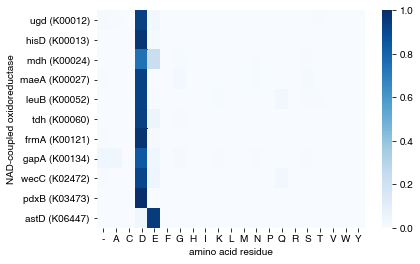

In [158]:
sns.heatmap(p.reset_index()[p.reset_index().id.isin(idl)].set_index('id'),cmap="Blues")
plt.xlabel('amino acid residue')
plt.ylabel('NAD-coupled oxidoreductase')
plt.savefig('orthogroups.DE.conservation.heatmap.svg')

In [148]:
help(sns.heatmap)

Help on function heatmap in module seaborn.matrix:

heatmap(data, *, vmin=None, vmax=None, cmap=None, center=None, robust=False, annot=None, fmt='.2g', annot_kws=None, linewidths=0, linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None, square=False, xticklabels='auto', yticklabels='auto', mask=None, ax=None, **kwargs)
    Plot rectangular data as a color-encoded matrix.
    
    This is an Axes-level function and will draw the heatmap into the
    currently-active Axes if none is provided to the ``ax`` argument.  Part of
    this Axes space will be taken and used to plot a colormap, unless ``cbar``
    is False or a separate Axes is provided to ``cbar_ax``.
    
    Parameters
    ----------
    data : rectangular dataset
        2D dataset that can be coerced into an ndarray. If a Pandas DataFrame
        is provided, the index/column information will be used to label the
        columns and rows.
    vmin, vmax : floats, optional
        Values to anchor the colormap, otherwise 